# Step 1: create a sine signal with frequency 10 Hz

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def sine_function(x, amplitude, frequency, phase):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)


# Step 2: One BPM signal simple sine and perturbed

10000 10000


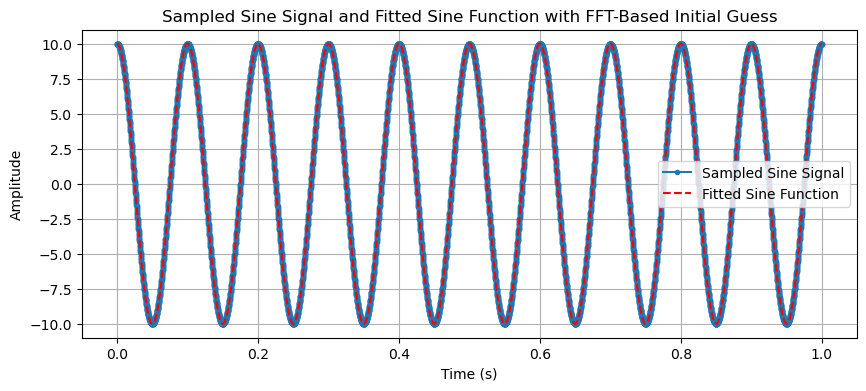

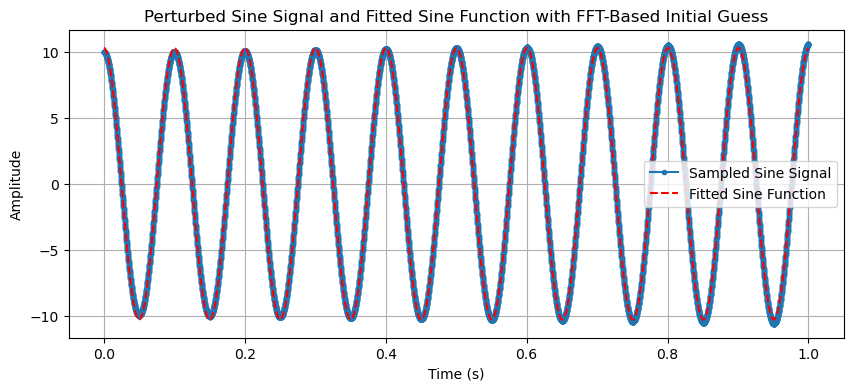

In [2]:
# Define parameters
sample_rate = 10000  # Sampling rate (samples per second)
duration = 1.0  # Duration in seconds
frequency = 10  # Frequency of the sine wave (Hz)
amplitude = 10  # Amplitude of the sine wave
phase=np.pi/2

# Generate time values
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate a sampled sine function
sine_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)

# Break the signal via kick
new_phase = np.pi/4.
new_frequency = 10.0
new_signal_noise = 0.05*np.sin(2 * np.pi * new_frequency * t + new_phase)

sine_signal_broken = sine_signal.copy()
print(len(sine_signal_broken), len(sine_signal))
for i in range(len(t)):
    if i%550 == 0 and not i==0:
        sine_signal_broken[i:] += new_signal_noise[i:]

# Calculate the FFT of the signal
fft_result = np.fft.fft(sine_signal)
fft_result_broken = np.fft.fft(sine_signal_broken)

# Extract the dominant frequency from the FFT
dominant_frequency = np.argmax(np.abs(fft_result)) / duration
dominant_frequency_broken = np.argmax(np.abs(fft_result_broken)) / duration

# Define the sine function to fit
def sine_function(t, A, f, phi):
    return A * np.sin(2 * np.pi * f * t + phi)

# Use the FFT-based estimate for the initial guess, with the correct amplitude
initial_guess = [amplitude, dominant_frequency, 0]
initial_guess_broken = [amplitude, dominant_frequency, 0]
#print(initial_guess)

# Fitting the sine function to the sampled data
fit_params, _ = curve_fit(sine_function, t, sine_signal, p0=initial_guess)
fit_params_broken, _ = curve_fit(sine_function, t, sine_signal_broken, p0=initial_guess)

# Plot the original sine function and the fitted sine function
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal, label='Sampled Sine Signal', marker='.')
plt.plot(t, sine_function(t, fit_params[0], fit_params[1], fit_params[2]), c='r', label='Fitted Sine Function', linestyle='--')
plt.title('Sampled Sine Signal and Fitted Sine Function with FFT-Based Initial Guess')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()
# Plot the broken sine function and the fitted sine function
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal_broken, label='Sampled Sine Signal', marker='.')
plt.plot(t, sine_function(t, fit_params_broken[0], fit_params_broken[1], fit_params_broken[2]), c='r', label='Fitted Sine Function', linestyle='--')
plt.title('Perturbed Sine Signal and Fitted Sine Function with FFT-Based Initial Guess')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


# Step 3: Multiple BPMs with a simple sine oscillation and two kick applied close to each other

C:\Users\Anna\Anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


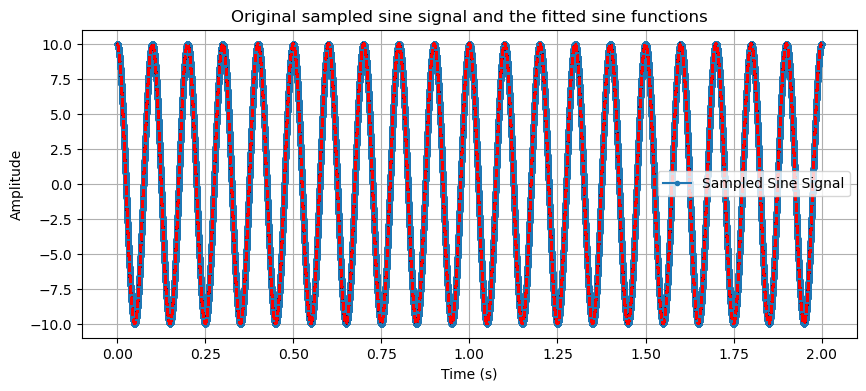

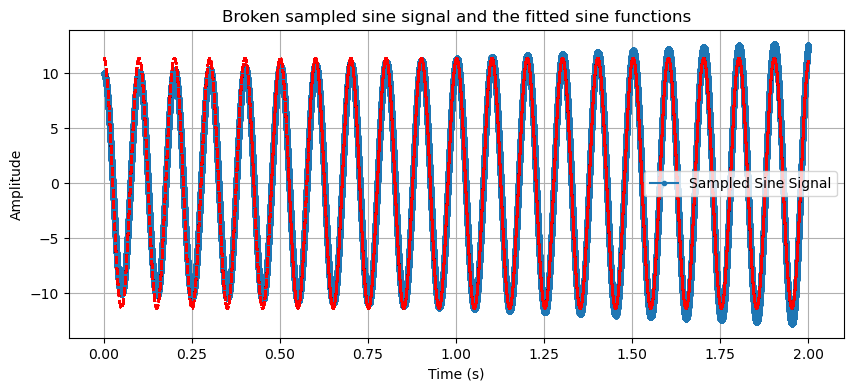

100


In [3]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

phase=np.pi/2

# Define parameters
sample_rate = 100000  # Sampling rate (samples per second)
duration = 2.0  # Duration in seconds
frequency = 10  # Frequency of the sine wave (Hz)
amplitude = 10  # Amplitude of the sine wave
phases_all = []
phases_all_broken = []

# Generate time values#
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate a sampled sine function
sine_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)

# Break the signal via kick
new_phase = np.pi/4.
new_frequency = 10.0
new_signal_noise = 0.005*np.sin(2 * np.pi * new_frequency * t + new_phase)
sine_signal_broken = sine_signal.copy()

for i in range(len(t)):
    if i%550 == 0 and not i==0:
        sine_signal_broken[i+40:] += new_signal_noise[i+40:]
        sine_signal_broken[i+45:] += new_signal_noise[i+45:]
        
# Define the sine function to fit
def sine_function(t, A, f, phi):
    return A * np.sin(2 * np.pi * f * t + phi) 

# Fit a sine function to every other point spaced 550 points apart (BPMs)
fit_params_list = []
fit_params_list_broken = []

for i in range(100):
    t_subset = t[i + 1*550::550]  # Important to take every BPM osc separately
    sine_signal_subset = sine_signal[i + 1*550::550]
    #plt.plot(t_subset, sine_signal_subset)
    sine_signal_subset_broken = sine_signal_broken[i + 1*550::550]

    # Calculate the FFT of the signal
    fft_result = np.fft.fft(sine_signal_subset)
    fft_result = fft_result / len(fft_result) * 2
    fft_result_broken = np.fft.fft(sine_signal_subset_broken)
    fft_result_broken = fft_result_broken / len(fft_result_broken) * 2
    myfreqs = np.fft.fftfreq(len(fft_result), d=t_subset[1] - t_subset[0])
    myfreqs_broken = np.fft.fftfreq(len(fft_result_broken), d=t_subset[1] - t_subset[0])

    # Extract the dominant frequency and phase from the FFT
    idx = np.argmax(abs(fft_result))
    guess_amplitude = abs(fft_result)[idx]
    guess_frequency = myfreqs[idx]
    guess_phase = np.angle(fft_result[idx])

    idx_broken = np.argmax(abs(fft_result_broken))
    guess_amplitude_broken = abs(fft_result_broken)[idx_broken]
    guess_frequency_broken = myfreqs_broken[idx_broken]
    guess_phase_broken = np.angle(fft_result_broken[idx_broken])

    initial_guess = [guess_amplitude, guess_frequency, guess_phase]
    initial_guess_broken = [guess_amplitude_broken, abs(guess_frequency_broken), abs(guess_phase_broken)]

    fit_params, _ = curve_fit(sine_function, t_subset, sine_signal_subset, p0=initial_guess)
    fit_params_list.append(fit_params)

    fit_params_broken, _ = curve_fit(sine_function, t_subset, sine_signal_subset_broken, p0=initial_guess_broken)
    fit_params_list_broken.append(fit_params_broken)

# Generate the fitted sine functions for visualization
fitted_signals = []
fitted_signals_broken = []

for fit_params in fit_params_list:
    fitted_signal = sine_function(t, fit_params[0], fit_params[1], fit_params[2])
    fitted_signals.append(fitted_signal)
    phases_all.append(fit_params[2])
    
for fit_params in fit_params_list_broken:
    fitted_signal = sine_function(t, fit_params[0], fit_params[1], fit_params[2])
    fitted_signals_broken.append(fitted_signal)
    phases_all_broken.append(fit_params[2])
    
# Plot the original sampled sine signal and the fitted sine functions
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal, label='Sampled Sine Signal', marker='.')
for fitted_signal in fitted_signals:
    plt.plot(t, fitted_signal, linestyle='--', color = 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.title('Original sampled sine signal and the fitted sine functions')

# Plot the broken sampled sine signal and the fitted sine functions
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal_broken, label='Sampled Sine Signal', marker='.')
for fitted_signal in fitted_signals_broken:
    plt.plot(t, fitted_signal, linestyle='--', c = 'red')
plt.title('Broken sampled sine signal and the fitted sine functions')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()
print(len(fit_params_list))

# Phase break detection at the two locations - BPM 40 and BPM 45

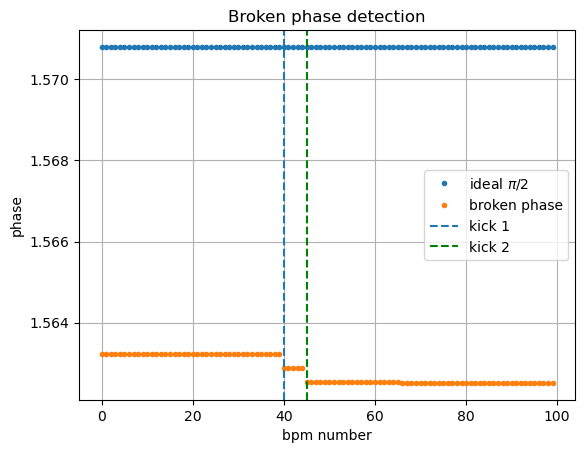

In [4]:
plt.plot(np.round(np.array(phases_all)%np.pi, 7), '.', label = 'ideal $\pi/2$')
plt.plot(np.round(np.array(phases_all_broken)%np.pi, 7),'.', label = 'broken phase') 
plt.xlabel('bpm number')
plt.ylabel('phase')
plt.title('Broken phase detection')
plt.grid(True)
plt.axvline(x = 40, linestyle = '--', label = 'kick 1')
plt.axvline(x = 45, linestyle = '--',color = 'g', label = 'kick 2')
plt.legend()

## This is the phase we put in $\pi/2$  and breaking of the phase 
Even though the fit is not perfectly fitting the amplitude the phase detection works. In the real case we don't have this extreme case.
